In [1]:
#  Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import joblib

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10,5)
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:


#  Load & Inspect Dataset
file_path = "customer_support_tickets.csv" 
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nSample Data:")
display(df.head())

print("\nMissing Values:")
display(df.isna().sum())

print("\nData Types:")
display(df.dtypes)

Dataset shape: (8469, 17)

Column Names: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']

Sample Data:


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0



Missing Values:


Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


Data Types:


Ticket ID                         int64
Customer Name                    object
Customer Email                   object
Customer Age                      int64
Customer Gender                  object
Product Purchased                object
Date of Purchase                 object
Ticket Type                      object
Ticket Subject                   object
Ticket Description               object
Ticket Status                    object
Resolution                       object
Ticket Priority                  object
Ticket Channel                   object
First Response Time              object
Time to Resolution               object
Customer Satisfaction Rating    float64
dtype: object

##  Data Cleaning

In [3]:
# unique Ticket Types 
print("\nUnique Ticket Types:")
print(df['Ticket Type'].unique())


Unique Ticket Types:
['Technical issue' 'Billing inquiry' 'Cancellation request'
 'Product inquiry' 'Refund request']


In [4]:
# unique Product Purchased
print("\nUnique Product Purchased:")
print(df['Product Purchased'].unique())



Unique Product Purchased:
['GoPro Hero' 'LG Smart TV' 'Dell XPS' 'Microsoft Office'
 'Autodesk AutoCAD' 'Microsoft Surface' 'Philips Hue Lights'
 'Fitbit Versa Smartwatch' 'Dyson Vacuum Cleaner' 'Nintendo Switch'
 'Microsoft Xbox Controller' 'Nintendo Switch Pro Controller'
 'Nest Thermostat' 'Sony PlayStation' 'GoPro Action Camera' 'Xbox'
 'LG Washing Machine' 'Canon EOS' 'HP Pavilion' 'Amazon Kindle'
 'Lenovo ThinkPad' 'Fitbit Charge' 'Adobe Photoshop' 'Google Pixel'
 'Amazon Echo' 'PlayStation' 'Samsung Galaxy' 'iPhone' 'LG OLED'
 'Sony Xperia' 'Apple AirPods' 'Sony 4K HDR TV' 'Canon DSLR Camera'
 'Roomba Robot Vacuum' 'Nikon D' 'Bose QuietComfort' 'Samsung Soundbar'
 'Asus ROG' 'Bose SoundLink Speaker' 'Google Nest' 'Garmin Forerunner'
 'MacBook Pro']


In [5]:
# TEXT STANDARDIZATION

# Define text columns
text_cols = ['Product Purchased', 'Ticket Type', 'Ticket Subject', 
             'Ticket Description', 'Ticket Status', 
             'Ticket Priority', 'Ticket Channel']

# Convert to lowercase & strip spaces
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().str.strip()

# Remove special characters from text fields for consistency
for col in text_cols:
    df[col] = df[col].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [6]:
#  DUPLICATES & MISSING VALUES

# Remove duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f" Removed {before - after} duplicate rows")

# Handle missing essential fields
essential_cols = ['Ticket ID', 'Product Purchased', 'Ticket Type', 'Ticket Description']
before_drop = df.shape[0]
df = df.dropna(subset=essential_cols)
after_drop = df.shape[0]
print(f"📝 Dropped {before_drop - after_drop} rows due to missing essential fields.")

# Inspect remaining missing values
print("\nRemaining Missing Values After Cleaning:")
print(df.isna().sum())

 Removed 0 duplicate rows
📝 Dropped 0 rows due to missing essential fields.

Remaining Missing Values After Cleaning:
Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


In [7]:
# CATEGORY NORMALIZATION

# Normalize Ticket Type categories
df['Ticket Type'] = df['Ticket Type'].replace({
    'refund issue': 'refund',
    'refund request': 'refund',
    'delivery delay': 'delivery',
    'delivery issue': 'delivery'
})

# Product Purchased: normalization for key overlaps
df['Product Purchased'] = df['Product Purchased'].replace({
    'gopro hero': 'gopro camera',
    'gopro action camera': 'gopro camera',
    'playstation': 'sony playstation',
    'canon eos': 'canon dslr',
    'canon dslr camera': 'canon dslr',
    'nest thermostat': 'google nest',
    'microsoft xbox controller': 'xbox',
    'fitbit versa smartwatch': 'fitbit',
    'fitbit charge': 'fitbit',
    'lg oled': 'lg tv',
    'lg smart tv': 'lg tv',
    'sony 4k hdr tv': 'sony tv'
})


In [8]:
#  DATA TYPE CONVERSIONS

#  Convert Ticket ID to object (string)
df['Ticket ID'] = df['Ticket ID'].astype(str)

df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], errors='coerce')
df['First Response Time'] = pd.to_datetime(df['First Response Time'], errors='coerce')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], errors='coerce')

#  Responded & Resolved Flags ---
df['Responded'] = df['First Response Time'].notna().astype(int)
df['Resolved'] = df['Resolution'].notna().astype(int)

In [9]:
#  STRUCTURING & SANITY CHECKS


# Reorder columns for cleaner display
desired_order = [
    'Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender',
    'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description',
    'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel',
    'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating', 'Resolved'
]
df = df[[col for col in desired_order if col in df.columns]]

# Prepare subsets for analysis
response_df = df.dropna(subset=['First Response Time'])
resolution_df = df.dropna(subset=['Time to Resolution'])

# Final shape & quick peek
print(f"\n Final cleaned dataset shape: {df.shape}")
display(df.head(5))



 Final cleaned dataset shape: (8469, 18)


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Resolved
0,1,Marisa Obrien,carrollallison@example.com,32,Other,gopro camera,2021-03-22,technical issue,product setup,im having an issue with the productpurchased p...,pending customer response,NaN,critical,social media,2023-06-01 12:15:36,NaT,NaN,0
1,2,Jessica Rios,clarkeashley@example.com,42,Female,lg tv,2021-05-22,technical issue,peripheral compatibility,im having an issue with the productpurchased p...,pending customer response,NaN,critical,chat,2023-06-01 16:45:38,NaT,NaN,0
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,dell xps,2020-07-14,technical issue,network problem,im facing a problem with my productpurchased t...,closed,Case maybe show recently my computer follow.,low,social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,1
3,4,Christina Dillon,bradleyolson@example.org,27,Female,microsoft office,2020-11-13,billing inquiry,account access,im having an issue with the productpurchased p...,closed,Try capital clearly never color toward story.,low,social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,1
4,5,Alexander Carroll,bradleymark@example.com,67,Female,autodesk autocad,2020-02-04,billing inquiry,data loss,im having an issue with the productpurchased p...,closed,West decision evidence bit.,low,email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,1


In [10]:
print("\nData Types:")
display(df.dtypes)


Data Types:


Ticket ID                               object
Customer Name                           object
Customer Email                          object
Customer Age                             int64
Customer Gender                         object
Product Purchased                       object
Date of Purchase                datetime64[ns]
Ticket Type                             object
Ticket Subject                          object
Ticket Description                      object
Ticket Status                           object
Resolution                              object
Ticket Priority                         object
Ticket Channel                          object
First Response Time             datetime64[ns]
Time to Resolution              datetime64[ns]
Customer Satisfaction Rating           float64
Resolved                                 int64
dtype: object

## Feature Engineering

In [11]:
# DATE COMPONENTS
# Extract useful time-based features from Date of Purchase
df['Purchase_Year'] = df['Date of Purchase'].dt.year
df['Purchase_Month'] = df['Date of Purchase'].dt.month
df['Purchase_Weekday'] = df['Date of Purchase'].dt.day_name()

# CUSTOMER AGE GROUPING 
# Create age bands for easier segmentation and analysis
age_bins = [0, 18, 30, 45, 60, np.inf]
age_labels = ['<18', '18–30', '31–45', '46–60', '60+']
df['Customer_Age_Group'] = pd.cut(df['Customer Age'], bins=age_bins, labels=age_labels)

#  RESPONSE & RESOLUTION FLAGS 
# Mark tickets with available response/resolution timestamps
df['Has_Response_Time'] = df['First Response Time'].notna().astype(int)
df['Has_Resolution_Time'] = df['Time to Resolution'].notna().astype(int)

#  TEXT LENGTH FEATURES
# These features capture how detailed the ticket subject/description is
df['Subject_Length'] = df['Ticket Subject'].astype(str).apply(len)
df['Description_Length'] = df['Ticket Description'].astype(str).apply(len)

# create urgency colunm
def engineer_urgency_features(df, text_col='Ticket Description'):
    """Creates extra numeric features for urgency classification."""
    texts = df[text_col].fillna("").astype(str)

    # Basic text stats
    df['desc_length'] = texts.apply(len)
    df['word_count'] = texts.apply(lambda x: len(x.split()))
    df['exclamation_count'] = texts.apply(lambda x: x.count('!'))
    df['uppercase_word_count'] = texts.apply(
        lambda x: sum(1 for w in x.split() if w.isupper() and len(w) > 1)
    )

    # Keyword-based urgency indicators
    urgent_keywords = [
        'urgent', 'asap', 'immediately', "can't", "cannot",
        'not working', 'broken', 'crashed','technical', 'fire', 'danger'
    ]
    df['urgent_keyword_count'] = texts.apply(
        lambda t: sum(1 for kw in urgent_keywords if kw in t.lower())
    )

    # Binary indicator if any urgent keyword is present
    df['has_urgent_keyword'] = (df['urgent_keyword_count'] > 0).astype(int)

    return df


# QUICK SANITY CHECK
print("\n Feature engineering complete. Preview of engineered features:")
display(df[[
    'Date of Purchase', 'Purchase_Year', 'Purchase_Month', 'Purchase_Weekday',
    'Customer Age', 'Customer_Age_Group',
    'Has_Response_Time', 'Has_Resolution_Time',
    'Ticket Type',
    'Subject_Length', 'Description_Length'
]].head())

#  Missing Values Check
print("\nRemaining Missing Values After Feature Engineering:")
print(df.isna().sum())



 Feature engineering complete. Preview of engineered features:


,Date of Purchase,Purchase_Year,Purchase_Month,Purchase_Weekday,Customer Age,Customer_Age_Group,Has_Response_Time,Has_Resolution_Time,Ticket Type,Subject_Length,Description_Length
0,2021-03-22,2021,3,Monday,32,31–45,1,0,technical issue,13,271
1,2021-05-22,2021,5,Saturday,42,31–45,1,0,technical issue,24,265
2,2020-07-14,2020,7,Tuesday,48,46–60,1,1,technical issue,15,254
3,2020-11-13,2020,11,Friday,27,18–30,1,1,billing inquiry,14,249
4,2020-02-04,2020,2,Tuesday,67,60+,1,1,billing inquiry,9,319



Remaining Missing Values After Feature Engineering:
Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
Resolved                           0
Purchase_Year                      0
Purchase_Month                     0
Purchase_Weekday                   0
Customer_Age_Group                 0
Has_Response_Time                  0
Has_Resolution_Time                0
Subject_Length                     0
Description_Length    

 ## Exploratory Data Analysis

 ### This section provides detailed analysis of correlations between ticket types, dates, and other variables to uncover patterns and insights.

In [12]:
# 1. DATASET OVERVIEW AND BASIC STATISTICS
print("=" * 60)
print("📊 COMPREHENSIVE DATASET OVERVIEW")
print("=" * 60)

print(f"📈 Dataset Shape: {df.shape}")
print(f"📅 Date Range: {df['Date of Purchase'].min()} to {df['Date of Purchase'].max()}")
print(f"🎯 Unique Ticket Types: {df['Ticket Type'].nunique()}")
print(f"🛍️ Unique Products: {df['Product Purchased'].nunique()}")
print(f"👥 Unique Customers: {df['Customer Name'].nunique()}")

print("\n📋 MISSING VALUES SUMMARY:")
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_pct.round(2)
}).sort_values('Missing %', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n📊 DATA TYPES SUMMARY:")
print(df.dtypes.value_counts())

📊 COMPREHENSIVE DATASET OVERVIEW
📈 Dataset Shape: (8469, 26)
📅 Date Range: 2020-01-01 00:00:00 to 2021-12-30 00:00:00
🎯 Unique Ticket Types: 5
🛍️ Unique Products: 35
👥 Unique Customers: 8028

📋 MISSING VALUES SUMMARY:
                              Missing Count  Missing %
Time to Resolution                     5700      67.30
Resolution                             5700      67.30
Customer Satisfaction Rating           5700      67.30
First Response Time                    2819      33.29

📊 DATA TYPES SUMMARY:
object            13
int64              6
datetime64[ns]     3
int32              2
float64            1
category           1
Name: count, dtype: int64


🎯 TICKET TYPE ANALYSIS
📊 Ticket Type Distribution:
  refund: 1,752 (20.7%)
  technical issue: 1,747 (20.6%)
  cancellation request: 1,695 (20.0%)
  product inquiry: 1,641 (19.4%)
  billing inquiry: 1,634 (19.3%)


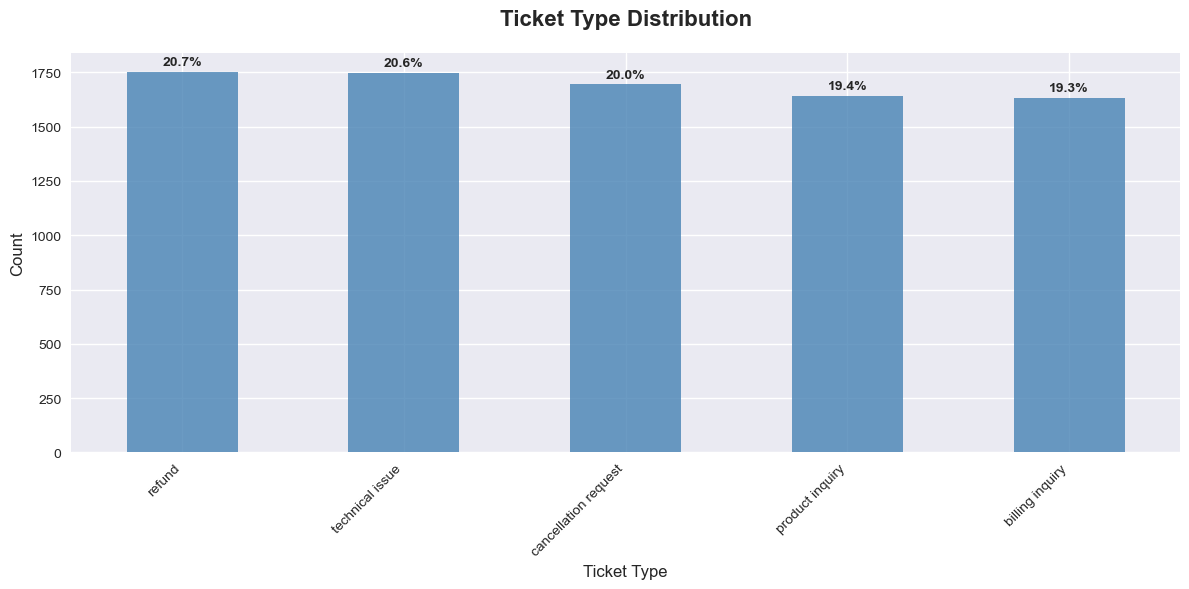

In [13]:
# TICKET TYPE DISTRIBUTION AND PATTERNS
print("=" * 60)
print("🎯 TICKET TYPE ANALYSIS")
print("=" * 60)

# Ticket type distribution
ticket_type_counts = df['Ticket Type'].value_counts()
ticket_type_pct = df['Ticket Type'].value_counts(normalize=True) * 100

print("📊 Ticket Type Distribution:")
for ticket_type, count in ticket_type_counts.items():
    pct = ticket_type_pct[ticket_type]
    print(f"  {ticket_type}: {count:,} ({pct:.1f}%)")

# Visualize ticket type distribution
plt.figure(figsize=(12, 6))
ax = ticket_type_counts.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Ticket Type Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ticket Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage labels on bars
for i, (ticket_type, count) in enumerate(ticket_type_counts.items()):
    pct = ticket_type_pct[ticket_type]
    ax.text(i, count + max(ticket_type_counts) * 0.01, f'{pct:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

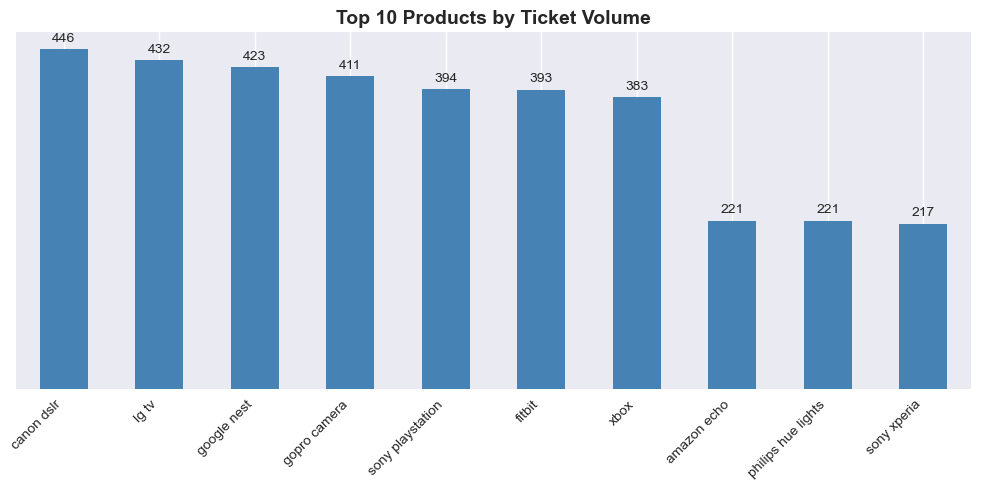

In [14]:
# --- Ticket counts by product ---
if 'Product Purchased' in df.columns:
    ticket_by_product = df['Product Purchased'].value_counts().head(10)

    # Plot
    ax = ticket_by_product.plot(kind='bar', color='steelblue', figsize=(10,5))

    #  Titles and labels
    plt.title('Top 10 Products by Ticket Volume', fontsize=14, fontweight='bold')
    plt.xlabel('')    # Remove x-axis label
    plt.ylabel('')    # Remove y-axis label
    plt.xticks(rotation=45, ha='right')

    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    #  Add data labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Product Purchased' column not found in dataframe.")


🛍️ PRODUCT ANALYSIS
📊 Top 10 Products by Ticket Volume:
  canon dslr: 446 (5.3%)
  lg tv: 432 (5.1%)
  google nest: 423 (5.0%)
  gopro camera: 411 (4.9%)
  sony playstation: 394 (4.7%)
  fitbit: 393 (4.6%)
  xbox: 383 (4.5%)
  amazon echo: 221 (2.6%)
  philips hue lights: 221 (2.6%)
  sony xperia: 217 (2.6%)

📊 Top Products vs Ticket Types (Top 10 products):
Ticket Type         billing inquiry  cancellation request  product inquiry  \
Product Purchased                                                            
canon dslr                       87                    85               87   
lg tv                            80                   105               89   
google nest                      87                    81               83   
gopro camera                     68                    82               74   
sony playstation                 82                    84               77   
fitbit                           65                    81               77   
xbox           

<Figure size 1600x1000 with 0 Axes>

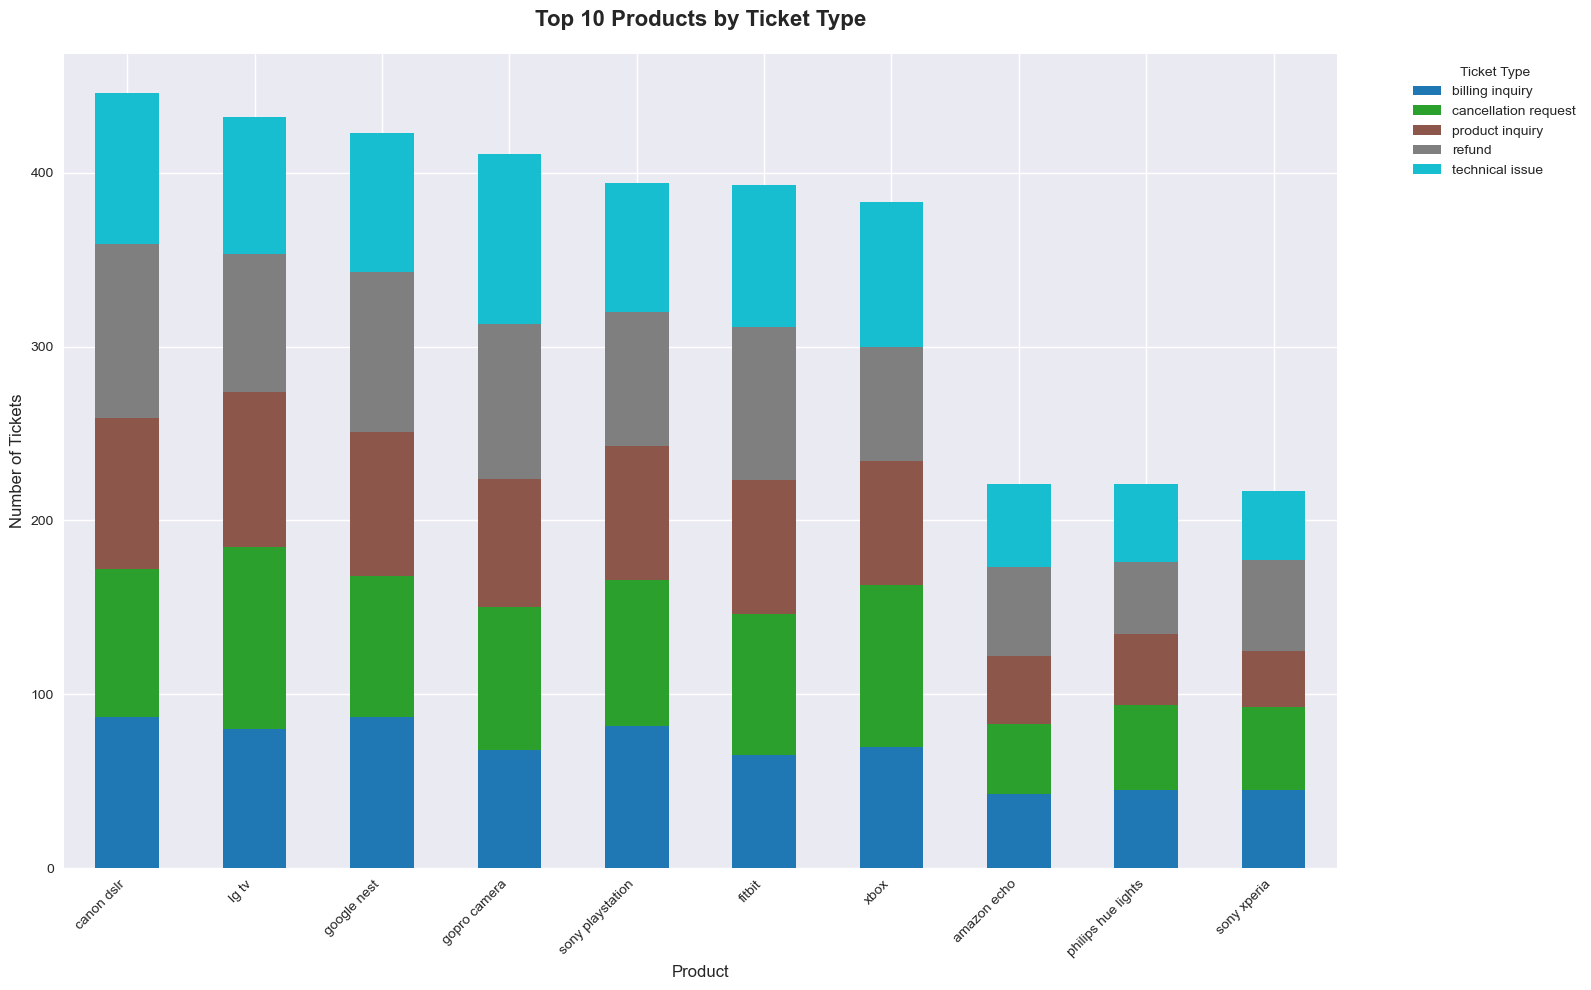

In [15]:
# 6. PRODUCT ANALYSIS AND CORRELATIONS
print("=" * 60)
print("🛍️ PRODUCT ANALYSIS")
print("=" * 60)

# Top products by ticket volume
top_products = df['Product Purchased'].value_counts().head(10)
print("📊 Top 10 Products by Ticket Volume:")
for product, count in top_products.items():
    pct = (count / len(df)) * 100
    print(f"  {product}: {count:,} ({pct:.1f}%)")

# Product vs Ticket Type analysis
product_ticket_crosstab = pd.crosstab(df['Product Purchased'], df['Ticket Type'])
print("\n📊 Top Products vs Ticket Types (Top 10 products):")
top_10_products = df['Product Purchased'].value_counts().head(10).index
print(product_ticket_crosstab.loc[top_10_products])

# Visualize product-ticket type relationship for top products
plt.figure(figsize=(16, 10))
product_ticket_subset = product_ticket_crosstab.loc[top_10_products]
product_ticket_subset.plot(kind='bar', stacked=True, figsize=(16, 10), colormap='tab10')
plt.title('Top 10 Products by Ticket Type', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Number of Tickets', fontsize=12)
plt.legend(title='Ticket Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

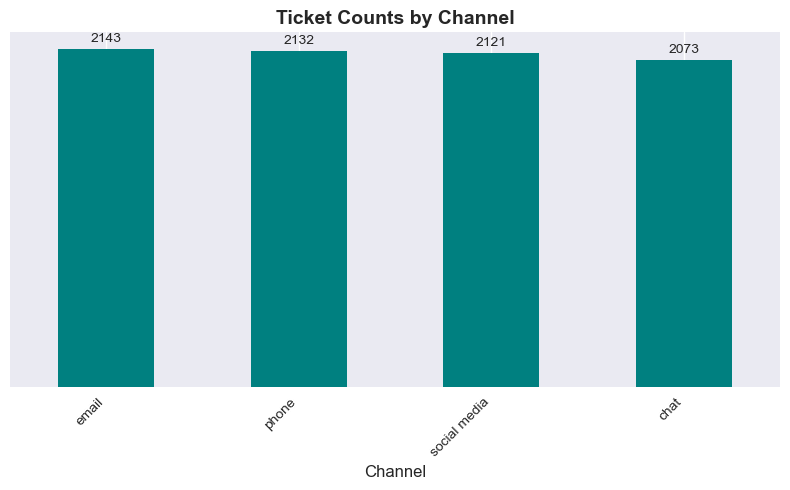

In [16]:


   # --- Ticket counts by channel ---
if 'Ticket Channel' in df.columns:
    ticket_by_channel = df['Ticket Channel'].value_counts()

    #  Plot 
    ax = ticket_by_channel.plot(kind='bar', color='teal', figsize=(8,5))
    plt.title('Ticket Counts by Channel', fontsize=14, fontweight='bold')
    plt.xlabel('Channel', fontsize=12)  
    plt.ylabel('')                       # Remove y-axis label
    plt.xticks(rotation=45, ha='right')

    # 🏷 Add data labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

    #  Clean up spines and axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()



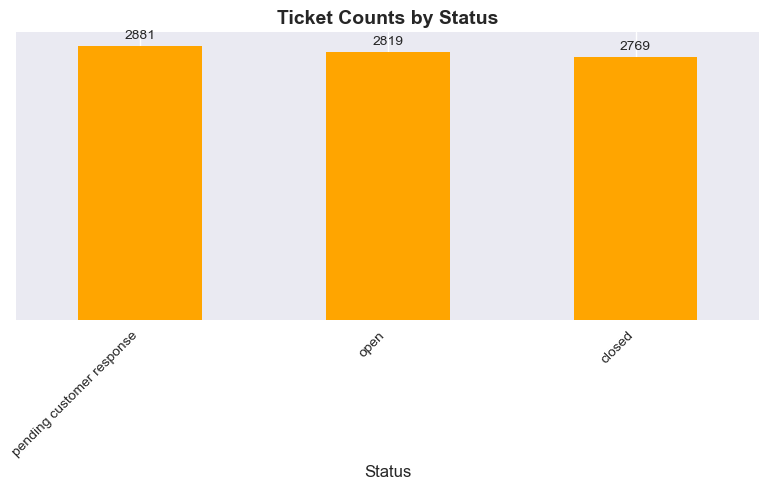

In [17]:
# --- Ticket counts by status ---
if 'Ticket Status' in df.columns:
    ticket_by_status = df['Ticket Status'].value_counts()

    # 🎨 Plot first
    ax = ticket_by_status.plot(kind='bar', color='orange', figsize=(8,5))
    plt.title('Ticket Counts by Status', fontsize=14, fontweight='bold')
    plt.xlabel('Status', fontsize=12)   # ✅ Add x-axis label
    plt.ylabel('')                      # Remove y-axis label
    plt.xticks(rotation=45, ha='right')

    # 🏷 Add data labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

    # 🧹 Clean chart aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_visible(False)   # ✅ Remove y-axis completely

    plt.tight_layout()
    plt.show()


In [18]:
# --- Ticket count by product (Top 10) ---
ticket_count_product = df['Product Purchased'].value_counts().head(10)
print("📌 Ticket Count by Product (Top 10):")
display(ticket_count_product)

# --- Ticket count by channel ---
if 'Ticket Channel' in df.columns:
    ticket_count_channel = df['Ticket Channel'].value_counts()
    print("\n📌 Ticket Count by Channel:")
    display(ticket_count_channel)

# --- Ticket count by status ---
if 'Ticket Status' in df.columns:
    ticket_count_status = df['Ticket Status'].value_counts()
    print("\n📌 Ticket Count by Status:")
    display(ticket_count_status)


📌 Ticket Count by Product (Top 10):


Product Purchased
canon dslr            446
lg tv                 432
google nest           423
gopro camera          411
sony playstation      394
fitbit                393
xbox                  383
amazon echo           221
philips hue lights    221
sony xperia           217
Name: count, dtype: int64


📌 Ticket Count by Channel:


Ticket Channel
email           2143
phone           2132
social media    2121
chat            2073
Name: count, dtype: int64


📌 Ticket Count by Status:


Ticket Status
pending customer response    2881
open                         2819
closed                       2769
Name: count, dtype: int64

📅 TIME-BASED ANALYSIS


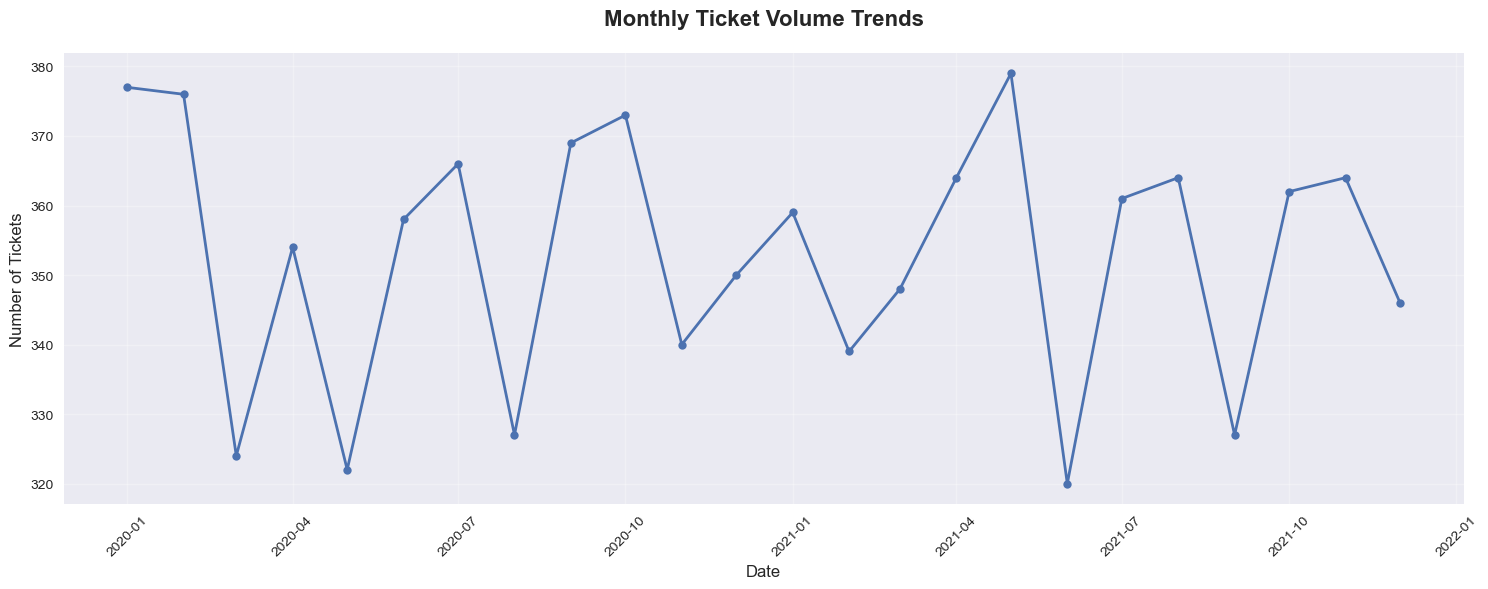


📊 Ticket Types by Month:
Ticket Type     billing inquiry  cancellation request  product inquiry  \
Purchase_Month                                                           
1                           137                   145              148   
2                           156                   133              140   
3                           136                   141              120   
4                           160                   147              135   
5                           128                   142              134   
6                           129                   132              121   
7                           151                   142              130   
8                           139                   124              140   
9                           130                   142              153   
10                          125                   155              142   
11                          104                   160              148   
12          

<Figure size 1400x800 with 0 Axes>

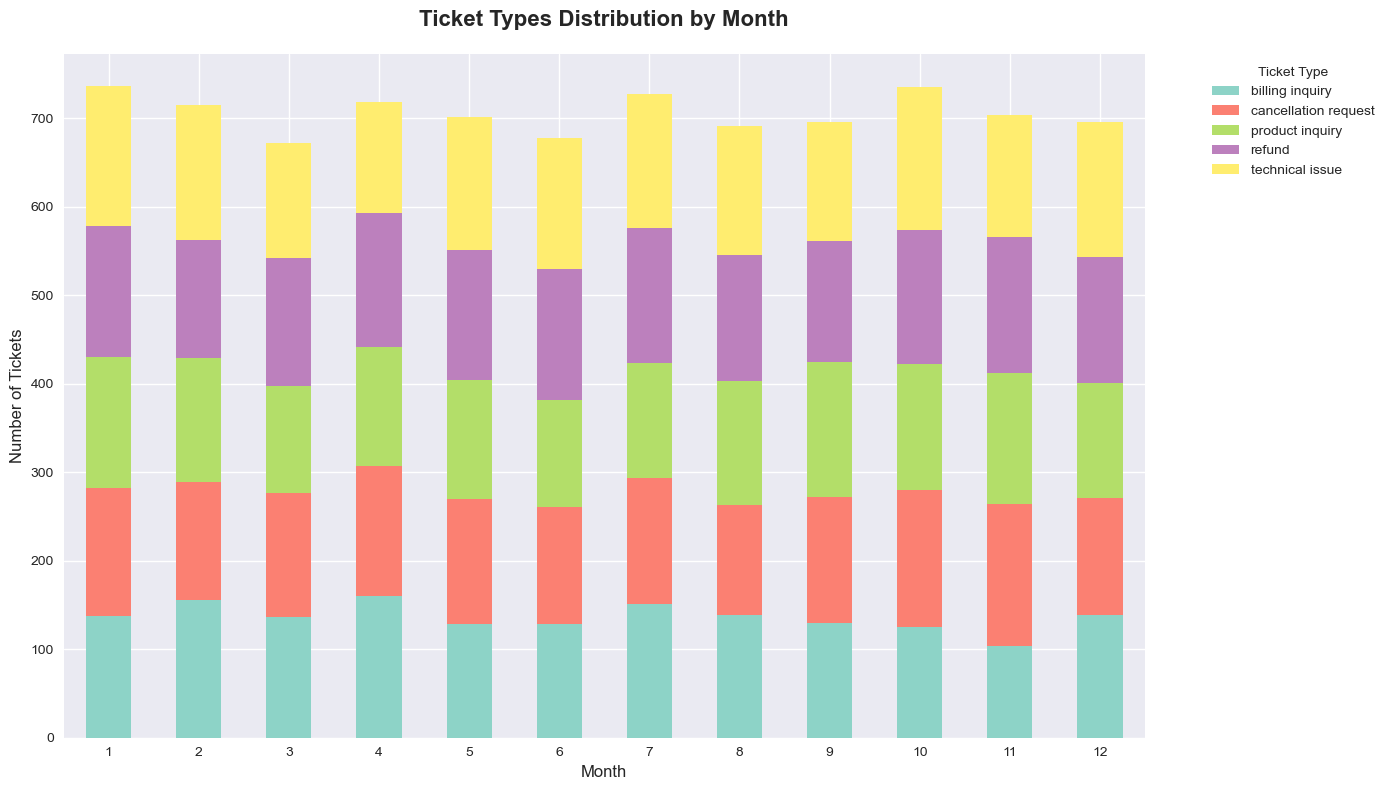

In [19]:
# 3. TIME-BASED ANALYSIS AND TRENDS
print("=" * 60)
print("📅 TIME-BASED ANALYSIS")
print("=" * 60)

# Monthly ticket trends
monthly_tickets = df.groupby(['Purchase_Year', 'Purchase_Month']).size().reset_index(name='Ticket_Count')
monthly_tickets['Date'] = pd.to_datetime(monthly_tickets['Purchase_Year'].astype(str) + '-' + monthly_tickets['Purchase_Month'].astype(str) + '-01')

# Plot monthly trends
plt.figure(figsize=(15, 6))
plt.plot(monthly_tickets['Date'], monthly_tickets['Ticket_Count'], marker='o', linewidth=2, markersize=6)
plt.title('Monthly Ticket Volume Trends', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Tickets', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ticket types by month
ticket_type_monthly = df.groupby(['Purchase_Month', 'Ticket Type']).size().unstack(fill_value=0)
print("\n📊 Ticket Types by Month:")
print(ticket_type_monthly)

# Visualize ticket types by month
plt.figure(figsize=(14, 8))
ticket_type_monthly.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set3')
plt.title('Ticket Types Distribution by Month', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Tickets', fontsize=12)
plt.legend(title='Ticket Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

In [20]:
# --- Average Resolution Time ---
if 'Time to Resolution' in df.columns:
    # Count how many tickets have resolution timestamps
    total_tickets = len(df)
    resolved_tickets = df['Time to Resolution'].notna().sum()
    resolution_rate = (resolved_tickets / total_tickets) * 100

    print(f"\n📌 Resolved Tickets: {resolved_tickets}/{total_tickets} ({resolution_rate:.1f}%)")

    # If you still want to compute average resolution time relative to first response
    valid_times = df.dropna(subset=['Time to Resolution', 'First Response Time']).copy()
    valid_times['Resolution_Duration_Hours'] = (
        (valid_times['Time to Resolution'] - valid_times['First Response Time'])
        .dt.total_seconds() / 3600
    )

    if not valid_times['Resolution_Duration_Hours'].empty:
        # Filter out negative values (data quality issue)
        positive_times = valid_times[valid_times['Resolution_Duration_Hours'] > 0]['Resolution_Duration_Hours']
        if not positive_times.empty:
            avg_resolution_time = positive_times.mean()
            print(f"⏱ Average Resolution Duration (hours): {avg_resolution_time:.2f}")
        else:
            print("⚠️ No valid positive resolution time differences available.")
            print(f"⏱ Raw average (including negative values): {valid_times['Resolution_Duration_Hours'].mean():.2f}")
    else:
        print("⚠️ No valid resolution time differences available.")


📌 Resolved Tickets: 2769/8469 (32.7%)
⏱ Average Resolution Duration (hours): 7.59


🎯 TICKET TYPE vs OTHER VARIABLES


C:\Users\maria\AppData\Local\Temp\ipykernel_13372\1347904006.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Ticket Type', y='Customer Age', palette='Set2')


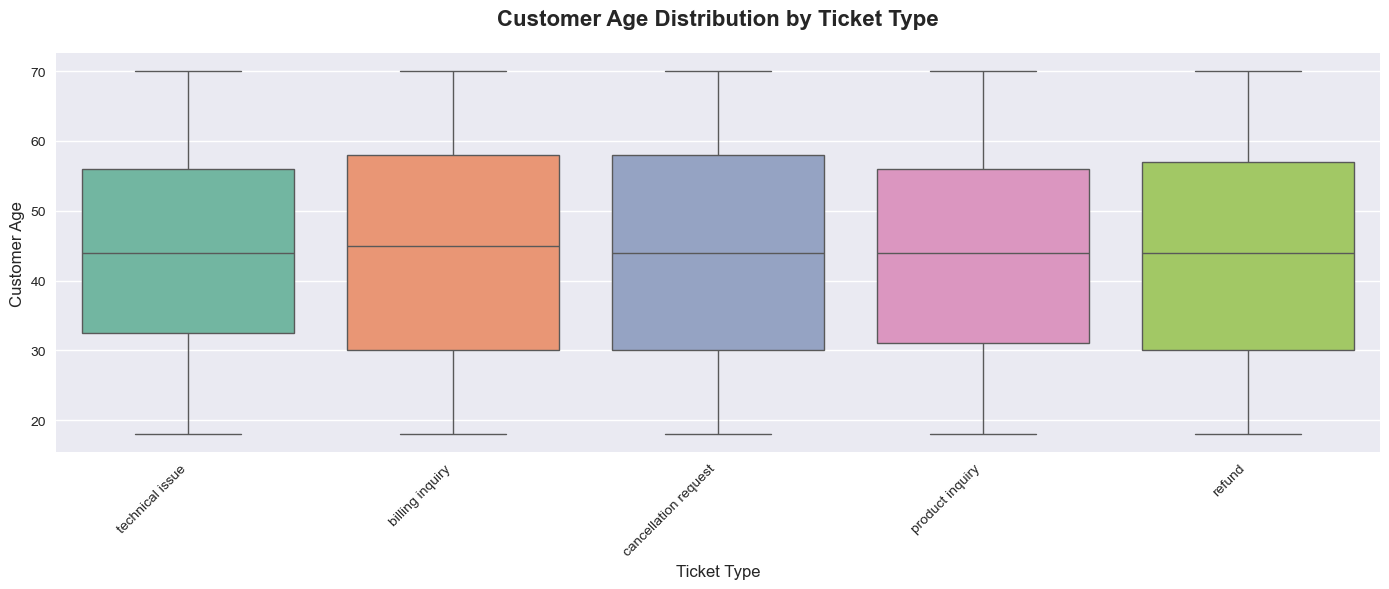


📊 Ticket Type Distribution by Month (%):
Purchase_Month         1    2    3    4    5    6    7    8    9    10   11  \
Ticket Type                                                                   
billing inquiry       8.4  9.5  8.3  9.8  7.8  7.9  9.2  8.5  8.0  7.6  6.4   
cancellation request  8.6  7.8  8.3  8.7  8.4  7.8  8.4  7.3  8.4  9.1  9.4   
product inquiry       9.0  8.5  7.3  8.2  8.2  7.4  7.9  8.5  9.3  8.7  9.0   
refund                8.4  7.6  8.3  8.6  8.4  8.4  8.7  8.2  7.8  8.7  8.8   
technical issue       9.0  8.8  7.4  7.2  8.6  8.5  8.6  8.3  7.7  9.2  7.9   

Purchase_Month         12  
Ticket Type                
billing inquiry       8.5  
cancellation request  7.8  
product inquiry       7.9  
refund                8.1  
technical issue       8.8  


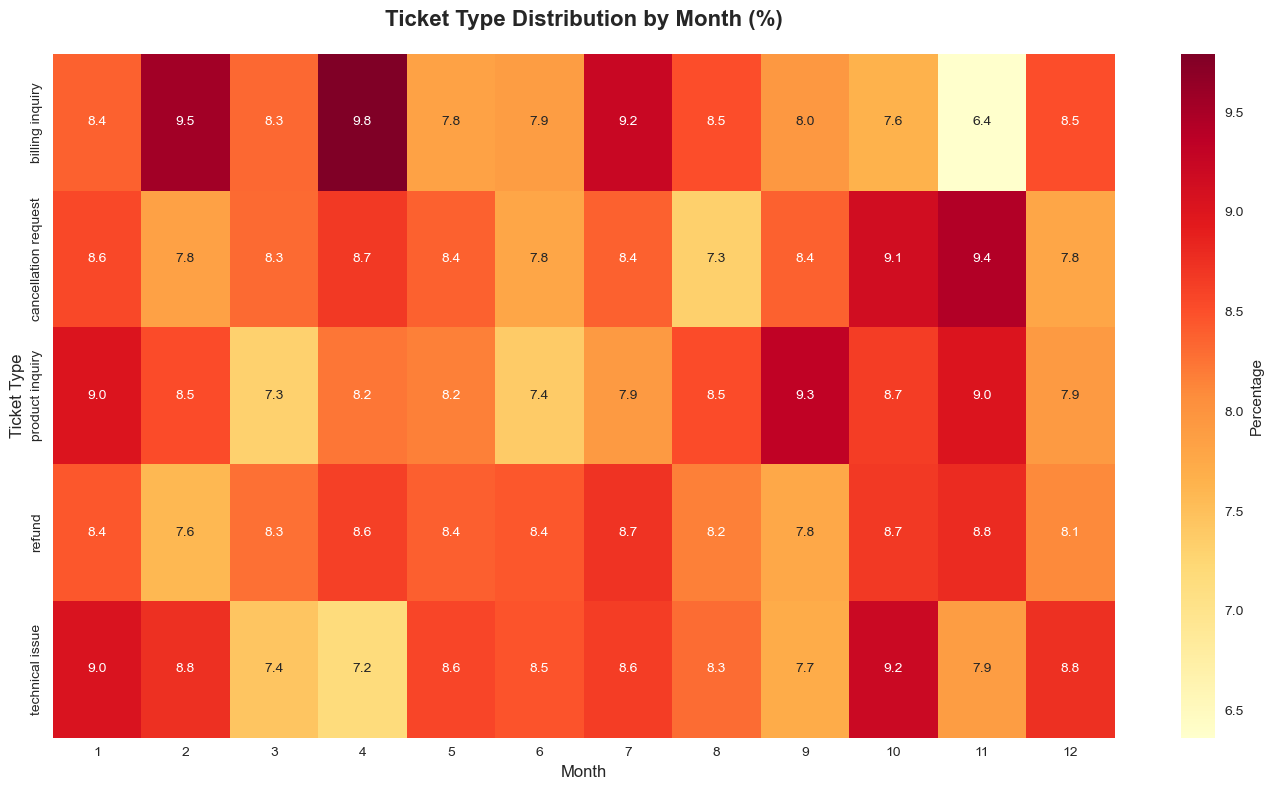

In [21]:
# 5. TICKET TYPE vs OTHER VARIABLES ANALYSIS
print("=" * 60)
print("🎯 TICKET TYPE vs OTHER VARIABLES")
print("=" * 60)

# Ticket Type vs Customer Age
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Ticket Type', y='Customer Age', palette='Set2')
plt.title('Customer Age Distribution by Ticket Type', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ticket Type', fontsize=12)
plt.ylabel('Customer Age', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Ticket Type vs Purchase Month
ticket_month_crosstab = pd.crosstab(df['Ticket Type'], df['Purchase_Month'], normalize='index') * 100
print("\n📊 Ticket Type Distribution by Month (%):")
print(ticket_month_crosstab.round(1))

# Visualize ticket type by month
plt.figure(figsize=(14, 8))
sns.heatmap(ticket_month_crosstab, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
plt.title('Ticket Type Distribution by Month (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Ticket Type', fontsize=12)
plt.tight_layout()
plt.show()

🔝 Top 5 Recurring Issue Keywords:
issue: 11530
problem: 2285
steps: 1390
noticed: 1208
persists: 1178


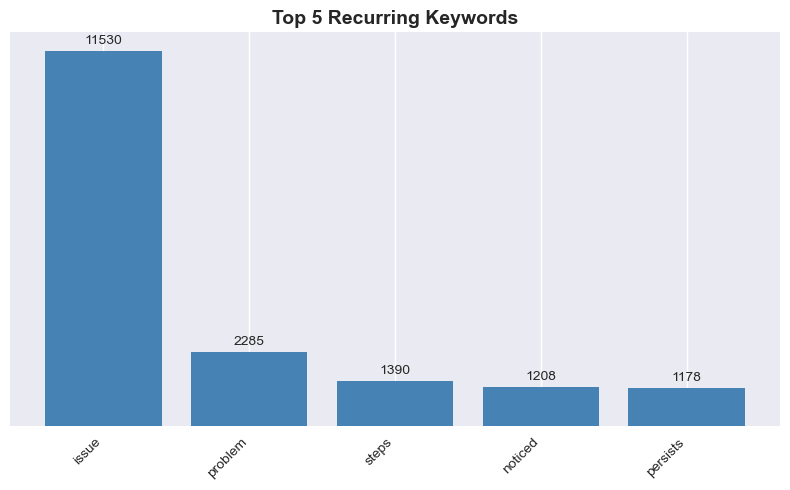


🔝 Top 5 Recurring Bigrams:
issue persists: 1176
resolve problem: 747
troubleshooting steps: 684
soon possible: 511
works fine: 507


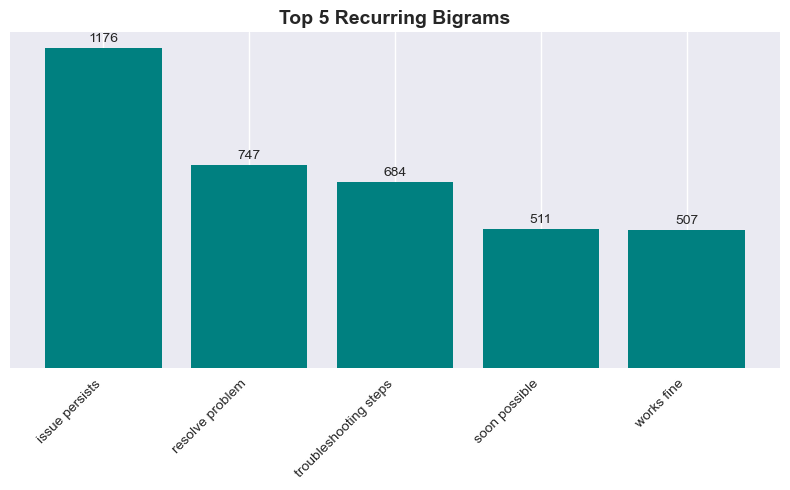

In [22]:
# Top 5 Recurring Issues (Based on Ticket Description) ---

# 1️Clean & preprocess text
stop_words = set(stopwords.words('english'))
extra_stops = {
    'please', 'assist', 'productpurchased', 'product',
    'data', 'software', 'ive', 'account', 'kindly', 'help'
}
stop_words = stop_words.union(extra_stops)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only letters & spaces
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df['cleaned_description'] = df['Ticket Description'].apply(clean_text)

# Helper function to plot top N phrases
def plot_top_phrases(data, title, color):
    phrases, freqs = zip(*data)
    plt.figure(figsize=(8,5))
    ax = plt.bar(phrases, freqs, color=color)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel('')
    plt.xlabel('')

    # Add labels on bars
    for i, v in enumerate(freqs):
        plt.text(i, v + max(freqs)*0.01, str(v), ha='center', va='bottom', fontsize=10, fontweight='medium')

    # Clean look
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

#  Top 5 single keywords
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_description'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
top5_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

print("🔝 Top 5 Recurring Issue Keywords:")
for word, freq in top5_words:
    print(f"{word}: {freq}")

plot_top_phrases(top5_words, 'Top 5 Recurring Keywords', 'steelblue')

# Top 5 bigrams
bigram_vec = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_bigram = bigram_vec.fit_transform(df['cleaned_description'])
bigram_freq = dict(zip(bigram_vec.get_feature_names_out(), X_bigram.toarray().sum(axis=0)))
top5_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n🔝 Top 5 Recurring Bigrams:")
for phrase, freq in top5_bigrams:
    print(f"{phrase}: {freq}")

plot_top_phrases(top5_bigrams, 'Top 5 Recurring Bigrams', 'teal')



In [23]:

# Summary Insights
print("\n📌 Key Insights Summary:")
print("• Top products with highest ticket volumes may indicate popular or problematic items.")
print("• Channel distribution helps identify customer contact preferences.")
print("• High resolution times for specific products suggest areas for operational improvement.")
print("• Frequent keywords highlight the most common customer pain points.")
print("• These insights can guide product teams, support prioritization, and knowledge base improvements.")



📌 Key Insights Summary:
• Top products with highest ticket volumes may indicate popular or problematic items.
• Channel distribution helps identify customer contact preferences.
• High resolution times for specific products suggest areas for operational improvement.
• Frequent keywords highlight the most common customer pain points.
• These insights can guide product teams, support prioritization, and knowledge base improvements.


In [43]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.tokenize import sent_tokenize

# ---------------------------
# 🧠 Synonym dictionary
# ---------------------------
SYNONYMS = {
    "refund": ["refund", "reversal", "cashback", "money back", "repayment"],
    "delivery": ["delivery", "shipment", "dispatch", "courier", "logistics"],
    "billing": ["billing", "invoice", "payment", "charge", "pricing"],
    "technical": ["technical", "bug", "crash", "error", "malfunction", "not working", "broken"],
    "cancellation": ["cancellation", "terminate", "close account", "stop service"],
    "urgent": ["urgent", "asap", "immediately", "critical", "important"]
}

def expand_query(query):
    """Expand query with synonyms to improve recall & precision."""
    q = query.lower()
    expanded = [query]
    for key, synonyms in SYNONYMS.items():
        if key in q:
            expanded.extend(synonyms)
    return " ".join(expanded)

# ---------------------------
# 🧼 Text Cleaning Helper
# ---------------------------
def clean_ticket_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"thanks.*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"best regards.*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"[^a-z0-9\s]", " ", text.lower())
    return re.sub(r"\s+", " ", text).strip()

# ---------------------------
# 🚀 Improved SimpleRAG
# ---------------------------
class SimpleRAG:
    def __init__(self, docs, doc_ids=None):
        self.raw_docs = list(docs)
        self.doc_ids = list(doc_ids) if doc_ids else list(range(len(self.raw_docs)))

        # Clean docs for indexing
        self.cleaned_docs = [clean_ticket_text(d) for d in self.raw_docs]

        # Use richer ngrams (1–3) and larger vocab
        self.vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
        self.doc_tfidf = self.vectorizer.fit_transform(self.cleaned_docs)

        # Build NN index
        self.nn = NearestNeighbors(n_neighbors=10, metric='cosine').fit(self.doc_tfidf)
        print(f"[SimpleRAG] Indexed {len(self.cleaned_docs)} documents — TF-IDF shape: {self.doc_tfidf.shape}")

    def retrieve(self, query, top_k=5):
        """Retrieve top_k relevant raw docs for expanded query."""
        q_expanded = expand_query(query)
        q_vec = self.vectorizer.transform([clean_ticket_text(q_expanded)])
        dists, idxs = self.nn.kneighbors(q_vec, n_neighbors=min(top_k, len(self.cleaned_docs)))
        sims = 1 - dists.flatten()
        idxs = idxs.flatten()
        return [(self.doc_ids[i], self.raw_docs[i], float(s)) for i, s in zip(idxs, sims)]

    def summarize_retrieved(self, retrieved, max_sentences=3):
        """Extractive summary using sentence scoring with TF-IDF."""
        sentences = []
        for doc_id, text, sim in retrieved:
            if isinstance(text, str):
                for s in sent_tokenize(text):
                    clean_s = clean_ticket_text(s)
                    if clean_s:
                        sentences.append((doc_id, s.strip(), clean_s))

        if not sentences:
            return ""

        sent_texts_clean = [s[2] for s in sentences]
        sent_tfidf = self.vectorizer.transform(sent_texts_clean)
        sent_scores = np.asarray(sent_tfidf.sum(axis=1)).ravel()

        top_idx = np.argsort(-sent_scores)[:max_sentences]
        return " ".join([sentences[i][1] for i in top_idx])

    def query(self, query_text, top_k=5):
        retrieved = self.retrieve(query_text, top_k)
        summary = self.summarize_retrieved(retrieved)
        return {"query": query_text, "retrieved": retrieved, "summary": summary}


In [44]:
# Build RAG
rag = SimpleRAG(
    docs=df['Ticket Description'].fillna("").tolist(),
    doc_ids=df['Ticket ID'].astype(str).tolist()
)

# Query
query = "Show me tickets about refund issues"
keyword = detect_ticket_type_from_query(query)
result = rag.query(query, top_k=5)

# Precision@5
p5 = precision_at_k(result['retrieved'], keyword, k=5)

print(f"🔎 Query: {query}")
print(f"📝 Summary: {result['summary']}")
print(f"🎯 Precision@5: {p5:.2f}")


[SimpleRAG] Indexed 8469 documents — TF-IDF shape: (8469, 10000)
🔎 Query: Show me tickets about refund issues
📝 Summary: im having an issue with the productpurchased please assist thank you

i have asked for a refund and i get to have the refund only with the purchase of the product the money i take from my account i need assistance as soon as possible because its affecting my work and productivity im having an issue with the productpurchased please assist

i want a refund when i put the original item back in stock please note that i can order multiple items at the same time and get a refund of ive tried troubleshooting steps mentioned in the user manual but the issue persists im having an issue with the productpurchased please assist

1 do i need to purchase a refund

there is a way to purchase a refund from zerohits but theres not a im unable to find the option to perform the desired action in the productpurchased could you please guide me through the steps
🎯 Precision@5: 1.00


In [57]:
## Evaluation and Testing RAG

test_queries = [
    "What are the most common refund issues?",
    "Show me tickets about delivery delays",
    "Are there any billing problems?",
    "What technical issues do users face?",
    "Tell me about urgent complaints"
]

for q in test_queries:
    result = rag.query(q, top_k=5)
    print(f"\n🔸 Query: {q}")
    print(f"🔸 Summary: {result['summary']}\n")
    print("📌 Top Retrieved Examples (Ticket ID, Similarity):")
    for doc_id, text, score in result['retrieved']:
        snippet = text[:250].replace("\n", " ")
        print(f"ID: {doc_id} | Similarity: {round(score,3)}")
        print(f"{snippet}...\n")
    print("-" * 80)



🔸 Query: What are the most common refund issues?
🔸 Summary: im encountering a software bug in the productpurchased whenever i try to perform a specific action the application crashes are there any updates or fixes available if so what are the most important points

as someone im unable to find the option to perform the desired action in the productpurchased could you please guide me through the steps ive accidentally deleted important data from my productpurchased is there any way to recover the deleted files i need them urgently

step 4 find the most compatible products

we can start to find the most compatible ive reviewed the troubleshooting steps on the official support website but they didnt resolve the problem im having an issue with the productpurchased please assist

1 what is the productpurchased why do they not specify the value on the product page

2 what are the prices ive reviewed the troubleshooting steps on the official support website but they didnt resolve the problem

## Urgent Classsifier

In [53]:

# Load dataset
df = pd.read_csv("customer_support_tickets_cleaned.csv")
df['Ticket Description'] = df['Ticket Description'].fillna("").astype(str)

# Expanded urgent keywords & phrases
urgent_keywords = [
    # Time sensitivity
    'urgent', 'asap', 'immediately', 'right away', 'as soon as possible',
    'quickly', 'hurry', 'soon', 'important',

    # Failure / error indicators
    'not working', 'broken', 'crashed', 'down', 'stopped',
    'failure', 'malfunction', 'dead', 'freeze', 'freezing', 'error', 'bug',

    # Severity / criticality
    'critical', 'high priority', 'top priority', 'emergency', 'severe',
    'major issue', 'serious problem', 'system down', 'data loss', 'security breach',

    # Frustration / escalation cues
    'blocked', 'urgent fix',
    'impossible to use', 'need help now', 'please help asap', 'i need this fixed',

    # Business impact
    'affecting work', 'impacting productivity', 'stopping operations', 
    'business critical', 'causing delay', 'loss of data', 'system failure'
]

# Convert to lowercase for matching
urgent_keywords = [kw.lower() for kw in urgent_keywords]

# Create the Urgent label
df['Urgent'] = df['Ticket Description'].str.lower().apply(
    lambda text: int(any(kw in text for kw in urgent_keywords))
)

# Check distribution again
print("\n🔸 Urgent label distribution after keyword expansion:")
print(df['Urgent'].value_counts())

# Save updated CSV
df.to_csv("customer_support_tickets_with_urgent.csv", index=False)
print("\n✅ Saved updated dataset with improved Urgent labeling!")



🔸 Urgent label distribution after keyword expansion:
Urgent
0    5841
1    2628
Name: count, dtype: int64

✅ Saved updated dataset with improved Urgent labeling!


In [58]:
from sklearn.metrics import classification_report, accuracy_score

# ---------------------------
# 🔸 Helper: Feature Engineering Function
# ---------------------------
def engineer_urgency_features(df, text_col='Ticket Description'):
    texts = df[text_col].fillna("").astype(str)

    # ✍️ Basic text-derived numerical features
    df['desc_length'] = texts.apply(len)
    df['word_count'] = texts.apply(lambda x: len(x.split()))
    df['exclamation_count'] = texts.apply(lambda x: x.count('!'))
    df['uppercase_word_count'] = texts.apply(
        lambda x: sum(1 for w in x.split() if w.isupper() and len(w) > 1)
    )

    # ⚡ Expanded urgency keywords and phrases
    urgent_keywords = [
        # Time sensitivity
        'urgent', 'asap', 'immediately', 'right away', 'as soon as possible',
        'quickly', 'hurry', 'soon', 'important',

        # Failure / error indicators
        'not working', 'broken', 'crashed', 'down', 'stopped', 'failure',
        'malfunction', 'dead', 'freeze', 'freezing', 'error', 'bug',

        # Severity / criticality
        'critical', 'high priority', 'top priority', 'emergency', 'severe',
        'major issue', 'serious problem', 'system down', 'data loss', 'security breach',

        # Frustration / escalation cues
        "can't", "cannot", "won't", 'not able', 'stuck', 'blocked', 'urgent fix',
        'impossible to use', 'need help now', 'please help asap', 'i need this fixed',

        # Business impact
        'affecting work', 'impacting productivity', 'stopping operations',
        'business critical', 'causing delay', 'loss of data', 'system failure'
    ]

    urgent_keywords = [kw.lower() for kw in urgent_keywords]

    # Count occurrences of urgent keywords
    df['urgent_keyword_count'] = texts.apply(
        lambda t: sum(1 for kw in urgent_keywords if kw in t.lower())
    )

    # Binary flag for presence of any urgent keyword
    df['has_urgent_keyword'] = (df['urgent_keyword_count'] > 0).astype(int)

    return df

# ---------------------------
# 🚀 Train + Save Model
# ---------------------------
def train_and_save_engineered_model(csv_path="customer_support_tickets_with_urgent.csv"):
    df = pd.read_csv(csv_path)
    text_col = 'Ticket Description'
    label_col = 'Urgent'

    # 1️⃣ Feature engineering
    df = engineer_urgency_features(df, text_col)

    # 2️⃣ TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_tfidf = vectorizer.fit_transform(df[text_col].fillna("").astype(str))

    # 3️⃣ Add numeric engineered features
    feature_cols = [
        'desc_length', 'word_count', 'exclamation_count',
        'uppercase_word_count', 'urgent_keyword_count', 'has_urgent_keyword'
    ]
    X_num = df[feature_cols].values
    X = hstack([X_tfidf, X_num])

    y = df[label_col]

    # 4️⃣ Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 5️⃣ Train model — upweight urgent class to improve recall
    model = LogisticRegression(max_iter=1000, class_weight={0: 0.5, 1: 10})
    model.fit(X_train, y_train)

    # 6️⃣ Evaluate
    y_pred = model.predict(X_test)
    print("\n📊 Urgency Classifier Report (with engineered features):")
    print(classification_report(y_test, y_pred))
    print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))

    # 7️⃣ Save artifacts
    joblib.dump(model, "urgency_model_engineered.joblib")
    joblib.dump(vectorizer, "urgency_vectorizer_engineered.joblib")
    joblib.dump(feature_cols, "urgency_feature_cols.joblib")

    print("\n💾 Model, vectorizer, and feature columns saved successfully!")

# Run training & save
train_and_save_engineered_model()



📊 Urgency Classifier Report (with engineered features):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1168
           1       0.97      1.00      0.98       526

    accuracy                           0.99      1694
   macro avg       0.98      0.99      0.99      1694
weighted avg       0.99      0.99      0.99      1694

✅ Accuracy: 0.99

💾 Model, vectorizer, and feature columns saved successfully!


In [59]:
from scipy.sparse import hstack
import numpy as np

# ✅ Step 3: Test with a new sample ticket
sample_ticket = "My device stopped working and I need it fixed ASAP"

v = clf_result['vectorizer']
model = clf_result['model']
feature_cols = clf_result['feature_cols']

# 1️⃣ TF-IDF transform
sample_tfidf = v.transform([sample_ticket])

# 2️⃣ Numeric feature engineering (must match training)
def compute_numeric_features(text):
    text = text or ""
    features = []
    features.append(len(text))  # desc_length
    features.append(len(text.split()))  # word_count
    features.append(text.count('!'))  # exclamation_count
    features.append(sum(1 for w in text.split() if w.isupper() and len(w) > 1))  # uppercase_word_count

    urgent_keywords = [
        'urgent', 'asap', 'immediately', "can't", "cannot",
        'not working', 'broken', 'crashed', 'technical', 'fire', 'danger'
    ]
    urgent_count = sum(1 for kw in urgent_keywords if kw in text.lower())
    features.append(urgent_count)  # urgent_keyword_count
    features.append(1 if urgent_count > 0 else 0)  # has_urgent_keyword

    return np.array(features).reshape(1, -1)

sample_num = compute_numeric_features(sample_ticket)

# 3️⃣ Combine TF-IDF + numeric features
sample_combined = hstack([sample_tfidf, sample_num])

# 4️⃣ Predict
prediction = model.predict(sample_combined)[0]
print(f"\n🚨 Predicted Urgency: {'URGENT' if prediction == 1 else 'NON-URGENT'}")



🚨 Predicted Urgency: URGENT


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

def train_urgent_classifier_smote_tuned(df, text_col='Ticket Description', label_col='Urgent'):
    # 1️⃣ Prepare text & labels
    texts = df[text_col].fillna("").astype(str)
    y = df[label_col]

    # 2️⃣ Train-test split (before SMOTE to avoid leakage)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        texts, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3️⃣ TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=10000,   # allow more features for tuning
        ngram_range=(1,2),
        min_df=3              # ignore rare words
    )
    X_train_tfidf = vectorizer.fit_transform(X_train_text)
    X_test_tfidf = vectorizer.transform(X_test_text)

    # 4️⃣ SMOTE balancing
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)

    print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
    print(f"After SMOTE:  {y_train_bal.value_counts().to_dict()}")

    # 5️⃣ Hyperparameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 5, 10],
        'penalty': ['l2'],      # l2 works best for TF-IDF usually
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': [None, 'balanced']
    }

    # 6️⃣ Grid search with cross-validation
    base_model = LogisticRegression(max_iter=2000)
    grid = GridSearchCV(
        base_model,
        param_grid,
        cv=3,
        scoring='f1_macro',   # prioritizing balance across classes
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_bal, y_train_bal)

    print(f"\n🏆 Best Params: {grid.best_params_}")
    best_model = grid.best_estimator_

    # 7️⃣ Evaluate on test set
    y_pred = best_model.predict(X_test_tfidf)
    print("\n📊 Urgency Classifier Report (SMOTE + Tuned):")
    print(classification_report(y_test, y_pred))
    print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))

    return {
        'vectorizer': vectorizer,
        'model': best_model,
        'best_params': grid.best_params_
    }

# ✅ Train tuned model
clf_smote_tuned = train_urgent_classifier_smote_tuned(df)


Before SMOTE: {0: 4673, 1: 2102}
After SMOTE:  {0: 4673, 1: 4673}
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🏆 Best Params: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

📊 Urgency Classifier Report (SMOTE + Tuned):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1168
           1       1.00      0.90      0.94       526

    accuracy                           0.97      1694
   macro avg       0.98      0.95      0.96      1694
weighted avg       0.97      0.97      0.97      1694

✅ Accuracy: 0.968


In [61]:
from sklearn.metrics import confusion_matrix, classification_report
from scipy.sparse import hstack
import numpy as np

# ==============================
# 🚨 Inspect Urgency Classifier Errors (Improved)
# ==============================

# Extract model components
vectorizer = clf_result['vectorizer']
model = clf_result['model']
feature_cols = clf_result['feature_cols']

# 1️⃣ Split data
texts = df['Ticket Description'].fillna("").astype(str)
y = df['Urgent']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
X_test_text = X_test_text.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 2️⃣ TF-IDF for test set
X_test_tfidf = vectorizer.transform(X_test_text)

# 3️⃣ Numeric feature engineering (same as training)
def compute_numeric_features(text_series):
    urgent_keywords = [
        'urgent', 'asap', 'immediately', "can't", "cannot",
        'not working', 'broken', 'crashed', 'technical', 'fire', 'danger'
    ]
    return np.vstack([
        [
            len(t),  # desc_length
            len(t.split()),  # word_count
            t.count('!'),  # exclamation_count
            sum(1 for w in t.split() if w.isupper() and len(w) > 1),  # uppercase_word_count
            sum(1 for kw in urgent_keywords if kw in t.lower()),  # urgent_keyword_count
            1 if any(kw in t.lower() for kw in urgent_keywords) else 0  # has_urgent_keyword
        ]
        for t in text_series
    ])

X_test_num = compute_numeric_features(X_test_text)
X_test_combined = hstack([X_test_tfidf, X_test_num])

# 4️⃣ Predictions
y_pred = model.predict(X_test_combined)

# 5️⃣ Confusion Matrix & Report
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(cm)
print("\n📑 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ Inspect False Negatives (Urgent = 1, Predicted = 0)
false_neg_idx = np.where((y_test == 1) & (y_pred == 0))[0]
print(f"\n❌ False Negatives (Urgent misclassified as Non-Urgent): {len(false_neg_idx)}")

# Show examples
false_negative_examples = X_test_text.iloc[false_neg_idx].head(10)
for i, txt in enumerate(false_negative_examples, 1):
    print(f"\n{i}. {txt}")



📊 Confusion Matrix:
[[1077   91]
 [   2  524]]

📑 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1168
           1       0.85      1.00      0.92       526

    accuracy                           0.95      1694
   macro avg       0.93      0.96      0.94      1694
weighted avg       0.95      0.95      0.95      1694


❌ False Negatives (Urgent misclassified as Non-Urgent): 2

1. the productpurchased is unable to establish a stable internet connection it keeps disconnecting intermittently how can i troubleshoot this network problem httpsbugsdebianorgcgibinbugreportcgi ive tried different settings and configurations on my productpurchased but the issue persists

2. im having an issue with the productpurchased please assist

 else 

thismessageseterrorinvalid product purchase 

 else 

thismessageset ive checked for software updates and my productpurchased is already running the latest version


In [64]:
# save model using joblib
joblib.dump(clf_result['vectorizer'], 'vectorizer.joblib')
joblib.dump(clf_result['model'], 'Ticket_urgency_model.joblib')


['Ticket_urgency_model.joblib']

In [65]:
# Build RAG object
rag = SimpleRAG(
    docs=df['Ticket Description'].fillna("").tolist(),
    doc_ids=df['Ticket ID'].astype(str).tolist()
)

# Save components
joblib.dump(rag.vectorizer, "rag_vectorizer.joblib")
joblib.dump(rag.doc_tfidf, "rag_doc_tfidf.joblib")
joblib.dump(rag.doc_ids, "rag_doc_ids.joblib")


[SimpleRAG] Indexed 8469 documents — TF-IDF shape: (8469, 10000)


['rag_doc_ids.joblib']

In [66]:


# These are the engineered features used during training
feature_cols = [
    'desc_length',
    'word_count',
    'exclamation_count',
    'uppercase_word_count',
    'urgent_keyword_count',
    'has_urgent_keyword'
]

# Save to file
joblib.dump(feature_cols, "urgency_feature_cols.joblib")
print("✅ Saved urgency_feature_cols.joblib")


✅ Saved urgency_feature_cols.joblib
